In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
hbar = 1
m = 1
omega = 1

x_min = -np.pi
x_max = np.pi
t_min = 0
t_max = 2 * np.pi

In [3]:
random.seed(101)
np.random.seed(101)
tf.random.set_seed(101)

# PINN

In [4]:
class PINN(tf.keras.Model):
  def __init__(self, layers):
    super(PINN, self).__init__()
    self.hidden_layers = [tf.keras.layers.Dense(units, activation="tanh") for units in layers[1:-1]]
    self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

  def call(self, inputs):
    x, t = inputs
    X = tf.stack([x, t], axis=1)

    for layer in self.hidden_layers:
      X = layer(X)

    output = self.output_layer(X)
    psi_real = output[:, 0]
    psi_imag = output[:, 1]
    return psi_real, psi_imag

In [5]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [6]:
n_collocation = 3140
n_initial = 314
n_boundary = 200

In [7]:
def generator():
    x_collocation_tf = tf.random.uniform(
        shape=(n_collocation,),
        minval=x_min,
        maxval=x_max,
        dtype=tf.float64
    )
    t_collocation_tf = tf.random.uniform(
        shape=(n_collocation,),
        minval=t_min,
        maxval=t_max,
        dtype=tf.float64
    )
    
    x_initial_tf = tf.random.uniform(
        shape=(n_initial,),
        minval=x_min,
        maxval=x_max,
        dtype=tf.float64
    )
    t_initial_tf = tf.fill(
        dims=(n_initial,),
        value=tf.constant(t_min, dtype=tf.float64)
    )
    
    boundary_left  = tf.fill([n_boundary // 2], tf.constant(x_min, dtype=tf.float64))
    boundary_right = tf.fill([n_boundary // 2], tf.constant(x_max, dtype=tf.float64))
    x_boundary_tf  = tf.concat([boundary_left, boundary_right], axis=0)
    t_boundary_tf  = tf.random.uniform(
        shape=(n_boundary,),
        minval=t_min,
        maxval=t_max,
        dtype=tf.float64
    )

    return (x_collocation_tf, t_collocation_tf,
            x_initial_tf, t_initial_tf,
            x_boundary_tf, t_boundary_tf)


In [8]:
learning_exp = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.001,
  decay_steps=2000,
  decay_rate=0.9,
)

# learning_piece = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#   [500, 100, 1500], [0.0, 0.001, 0.0005, 0.0001]
# )

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_exp, beta_1=0.09, beta_2=0.999)

In [9]:
model = PINN(layers)

In [10]:
@tf.function
def loss_function():
    #points generation
    x_collocation_tf, t_collocation_tf, x_initial_tf, t_initial_tf, x_boundary_tf, t_boundary_tf = generator()
    
    #pde loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x_collocation_tf, t_collocation_tf])
    
        psi_real, psi_img = model((x_collocation_tf, t_collocation_tf))
        psi = tf.complex(psi_real, psi_img)
        psi = tf.cast(psi, tf.complex128)
    
        d_psi_dx = tape.gradient(psi, x_collocation_tf)
        d_psi_dt = tape.gradient(psi, t_collocation_tf)
    
    d2_psi_dx2 = tape.gradient(d_psi_dx, x_collocation_tf)
    
    del tape
    
    i = tf.complex(0.0, 1.0)
    i = tf.cast(i, dtype=tf.complex128)
    d_psi_dt = tf.cast(d_psi_dt, tf.complex128)
    d2_psi_dx2 = tf.cast(d2_psi_dx2, tf.complex128)
    
    residual = i * d_psi_dt + 0.5 * d2_psi_dx2 - tf.cast(0.5 * (x_collocation_tf ** 2), tf.complex128) * psi
    physics_loss = tf.reduce_mean(tf.square(tf.abs(residual)))
    
    
    
    
    #initial condition loss
    psi_real_initial, psi_img_initial = model((x_initial_tf, t_initial_tf))
    psi_initial = tf.complex(psi_real_initial, psi_img_initial)
    psi_initial = tf.cast(psi_initial, tf.complex128)
    
    psi_0 = ((1 / np.pi) ** 0.25) * tf.exp(-0.5 * (x_initial_tf ** 2))
    psi_1 = psi_0 * np.sqrt(2) * x_initial_tf
    psi_initial_actual = (psi_0 + psi_1) / np.sqrt(2)
    psi_initial_actual = tf.cast(psi_initial_actual, tf.complex128)
    
    initial_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_initial - psi_initial_actual)))
    
    
    
    
    #boundary condition loss
    psi_real_boundary, psi_img_boundary = model((x_boundary_tf, t_boundary_tf))
    psi_boundary = tf.complex(psi_real_boundary, psi_img_boundary)
    psi_boundary = tf.cast(psi_boundary, tf.complex128)
    boundary_condition_loss = tf.reduce_mean(tf.square(tf.abs(psi_boundary)))




    return physics_loss, initial_condition_loss, boundary_condition_loss

In [11]:
epochs = 150000
history = []

for epoch in range(1, epochs+1):
    with tf.GradientTape() as tape:
        physics_loss, initial_condition_loss, boundary_condition_loss = loss_function()
        total_loss = physics_loss + initial_condition_loss + boundary_condition_loss

    gradients = tape.gradient(total_loss, model.trainable_variables)
    del tape

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    history.append({
        'total_loss': total_loss.numpy(),
        'physics_loss': physics_loss.numpy(),
        'initial_condition_loss': initial_condition_loss.numpy(),
        'boundary_condition_loss': boundary_condition_loss.numpy(),
    })

    if (epoch % 5000 == 0):
        print(f"Epoch {epoch}/{epochs}\nTotal Loss: {total_loss.numpy():.4e}\nPhysics Loss: {physics_loss.numpy():.4e}\nInitial Condition Loss: {initial_condition_loss.numpy():.4e}\nBoundary Condition Loss: {boundary_condition_loss.numpy():.4e}")
        print("--------------------------------------------------")

Epoch 5000/150000
Total Loss: 4.3096e-01
Physics Loss: 2.1566e-01
Initial Condition Loss: 1.7276e-01
Boundary Condition Loss: 4.2538e-02
--------------------------------------------------
Epoch 10000/150000
Total Loss: 2.0477e-01
Physics Loss: 5.2813e-02
Initial Condition Loss: 1.4210e-01
Boundary Condition Loss: 9.8594e-03
--------------------------------------------------
Epoch 15000/150000
Total Loss: 4.3157e-02
Physics Loss: 2.3903e-02
Initial Condition Loss: 1.8547e-02
Boundary Condition Loss: 7.0677e-04
--------------------------------------------------
Epoch 20000/150000
Total Loss: 1.2049e-01
Physics Loss: 8.4797e-02
Initial Condition Loss: 2.3100e-02
Boundary Condition Loss: 1.2594e-02
--------------------------------------------------
Epoch 25000/150000
Total Loss: 5.5752e-02
Physics Loss: 4.0688e-02
Initial Condition Loss: 1.0066e-02
Boundary Condition Loss: 4.9976e-03
--------------------------------------------------
Epoch 30000/150000
Total Loss: 3.4912e-02
Physics Loss: 

In [12]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

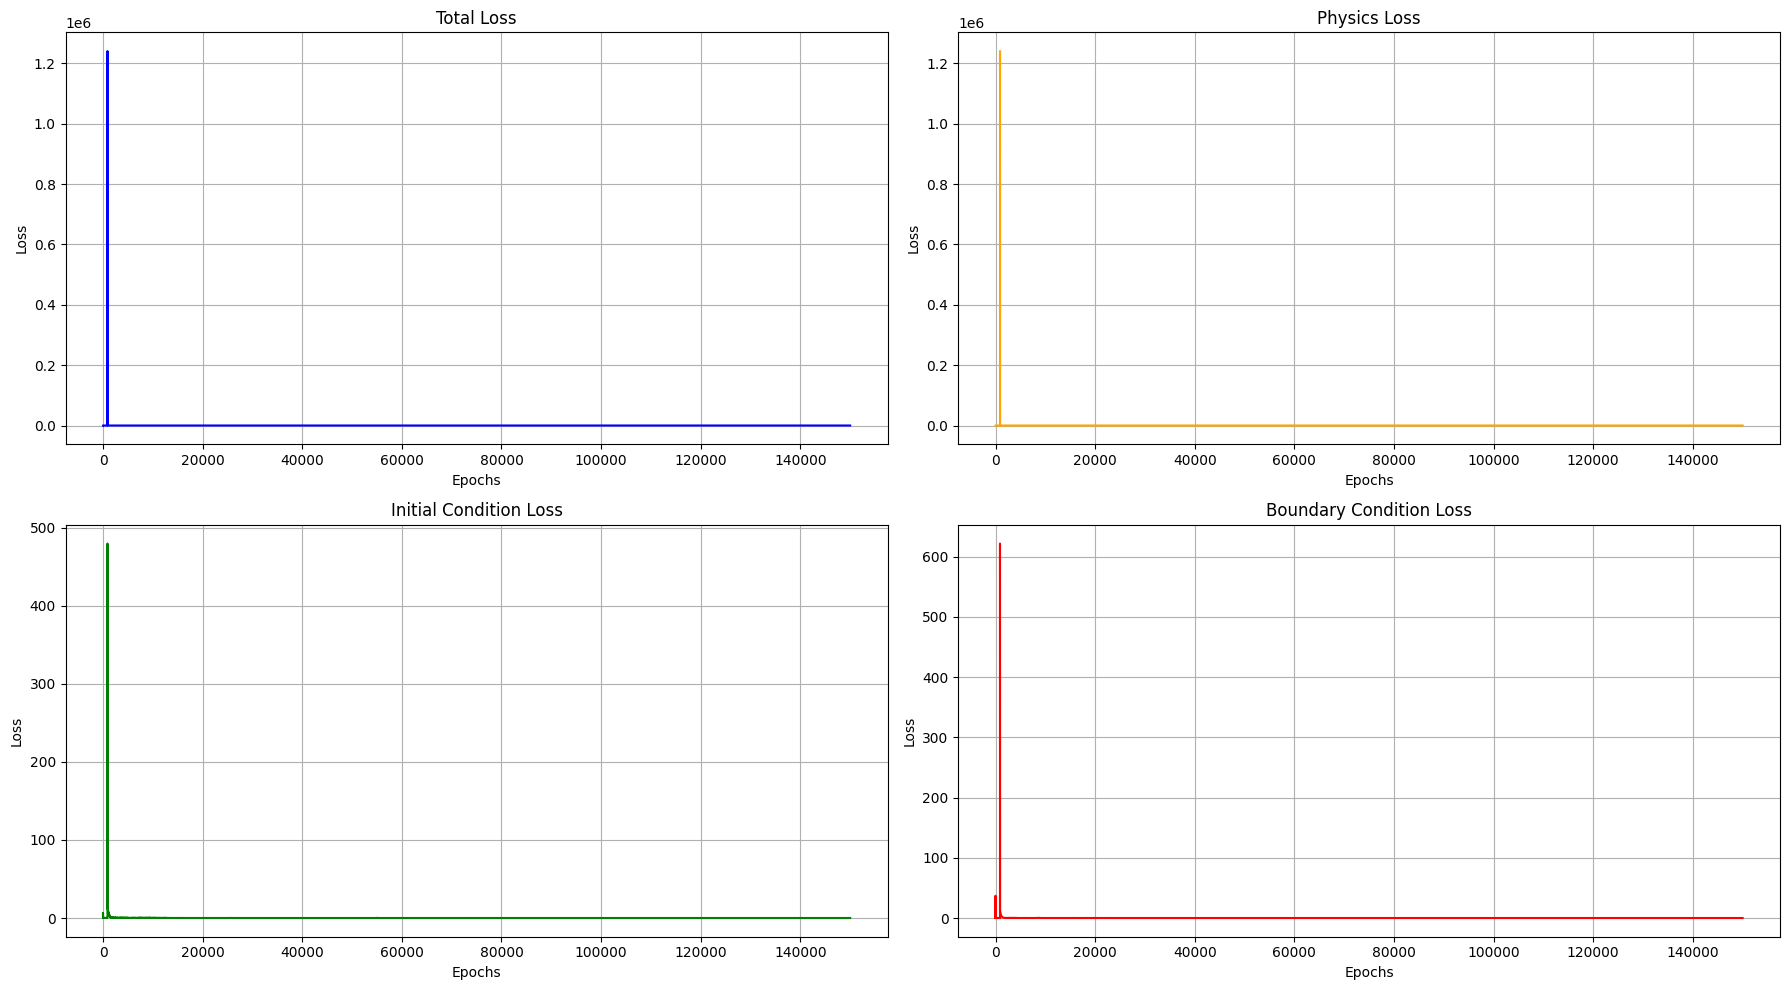

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

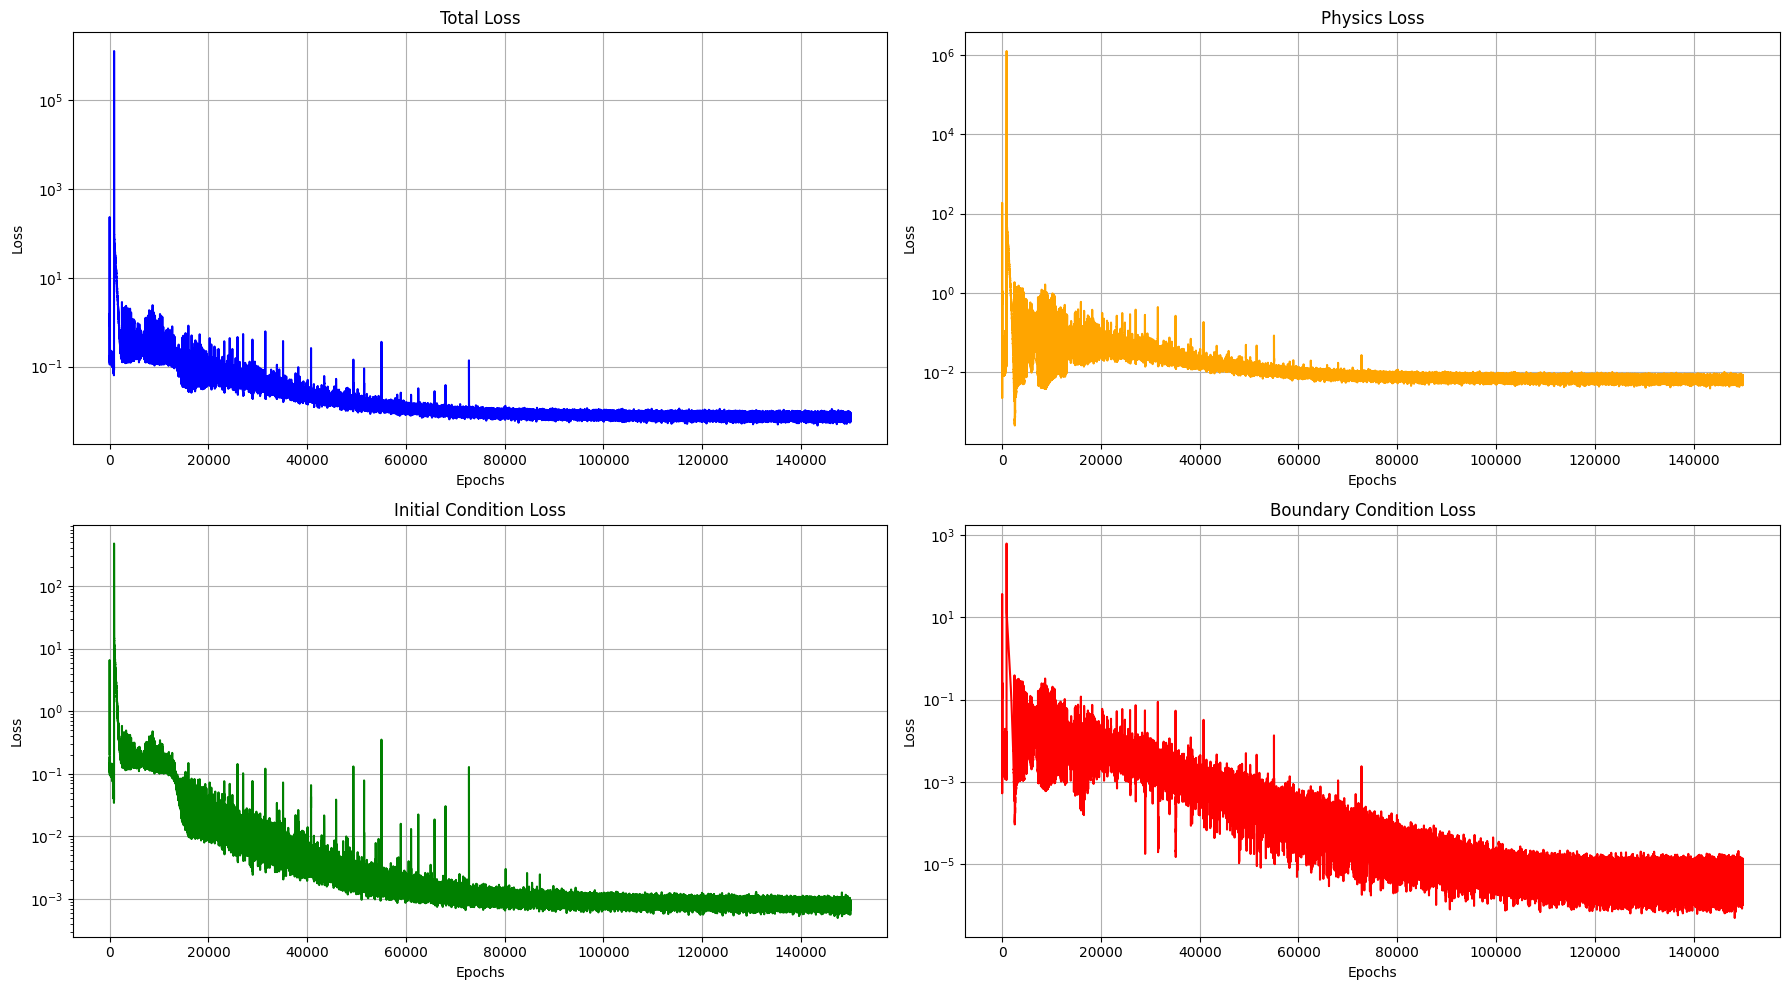

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

# Testing

In [15]:
Nx = 628
Nt = 628

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [16]:
def analytical(x, t):
    A = (1 / np.sqrt(2)) * ((1 / np.pi) ** 0.25) * np.exp(-(x ** 2) / 2)
    B1 = np.exp(-1j * 0.5 * t)
    B2 = np.exp(-1j * 1.5 * t) * np.sqrt(2) * x
    return A * (B1 + B2)

In [17]:
psi_real_analytical = np.zeros((Nx, Nt), dtype=np.float64)
psi_img_analytical = np.zeros((Nx, Nt), dtype=np.float64)

for i, x in enumerate(x_values):
    for j, t in enumerate(t_values):
        psi_x_t = analytical(x, t)

        psi_real_analytical[i, j] = np.real(psi_x_t)
        psi_img_analytical[i, j] = np.imag(psi_x_t)

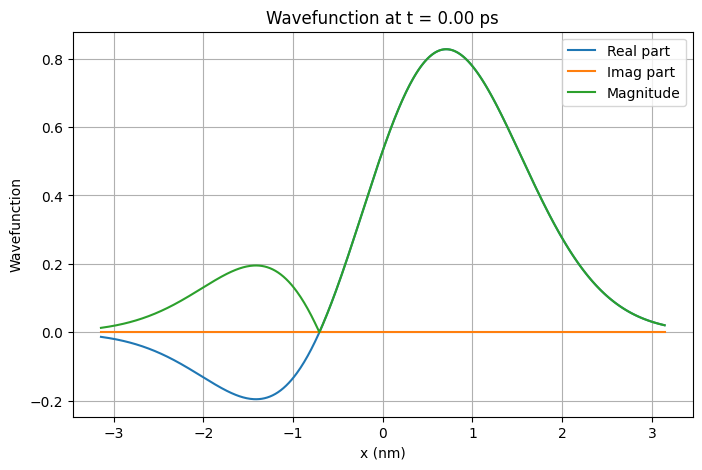

In [18]:
time_index = 0
time_chosen = t_values[time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical**2 + psi_img_slice_analytical**2)

plt.figure(figsize=(8,5))
plt.plot(x_values, psi_real_slice_analytical, label='Real part')
plt.plot(x_values, psi_img_slice_analytical, label='Imag part')
plt.plot(x_values, psi_mag_slice_analytical, label='Magnitude')
plt.title(f'Wavefunction at t = {time_chosen:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()


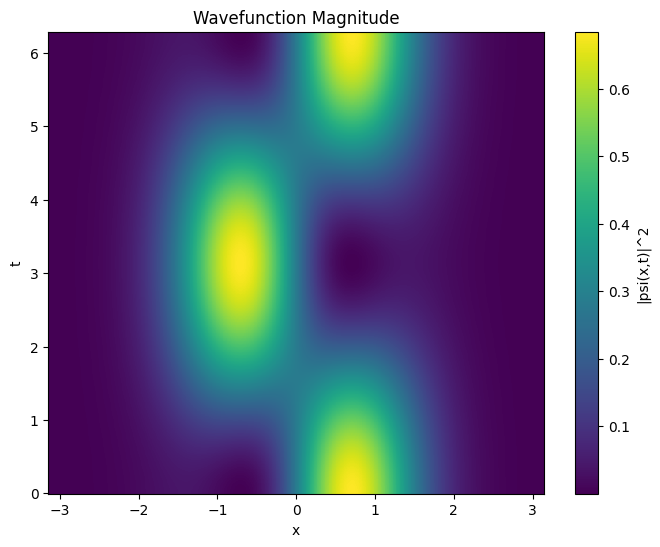

In [19]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_analytical ** 2 + psi_img_analytical ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wavefunction Magnitude')
plt.show()

In [20]:
x_values_tf = tf.convert_to_tensor(x_values)
t_values_tf = tf.convert_to_tensor(t_values)

x_grid, t_grid = tf.meshgrid(x_values_tf, t_values_tf, indexing="ij")

x_flat = tf.reshape(x_grid, [-1])
t_flat = tf.reshape(t_grid, [-1])

psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

psi_real_pinn = tf.reshape(psi_real_pinn, (Nx, Nt))
psi_img_pinn = tf.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = psi_real_pinn.numpy()
psi_img_pinn = psi_img_pinn.numpy()

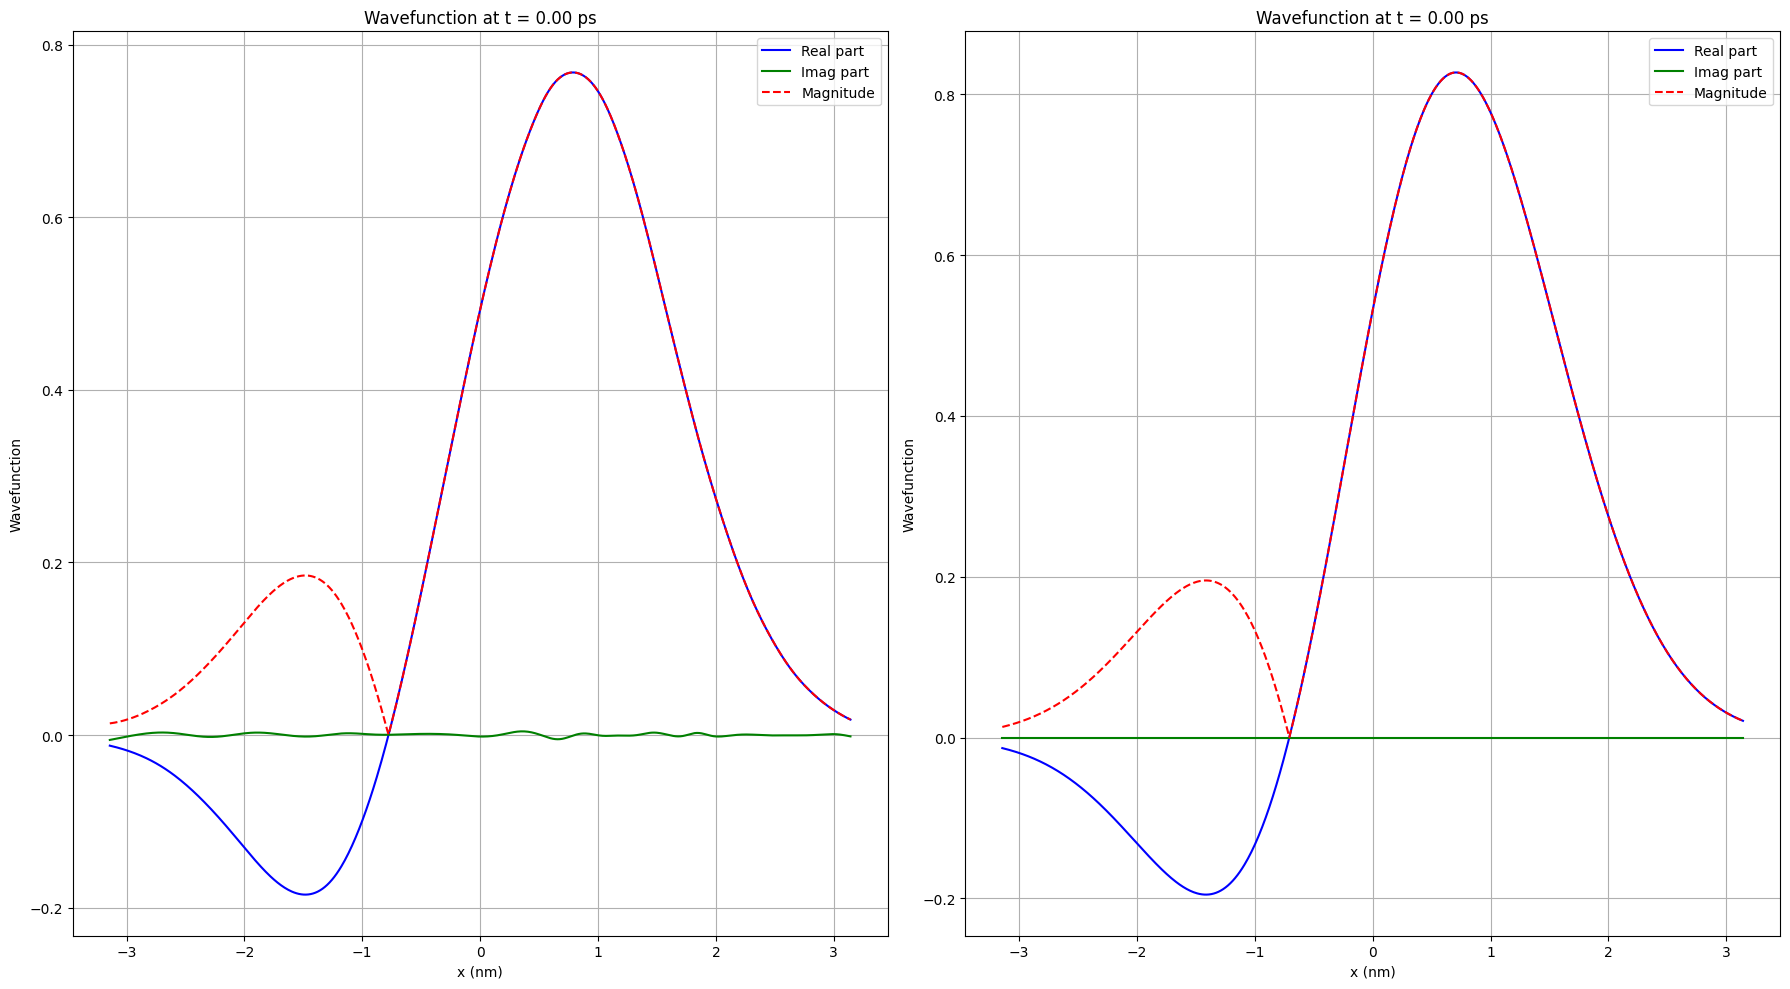

In [24]:
time_index = 0
time_chosen = t_values[time_index]

psi_real_slice_pinn = psi_real_pinn[:, time_index]
psi_imag_slice_pinn = psi_img_pinn[:, time_index]

psi_real_slice_analytical = psi_real_analytical[:, time_index]
psi_img_slice_analytical = psi_img_analytical[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn ** 2 + psi_imag_slice_pinn ** 2)
psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical ** 2 + psi_img_slice_analytical ** 2)

fig, axs = plt.subplots(1, 2, figsize=(18, 10))

#pinn
axs[0].plot(x_values, psi_real_slice_pinn, label='Real part', color='blue')
axs[0].plot(x_values, psi_imag_slice_pinn, label='Imag part', color='green')
axs[0].plot(x_values, psi_mag_slice_pinn, '--', label='Magnitude', color='red')
axs[0].set_title(f'Wavefunction at t = {time_chosen:.2f} ps')
axs[0].set_xlabel('x (nm)')
axs[0].set_ylabel('Wavefunction')
axs[0].legend()
axs[0].grid(True)

#analytical
axs[1].plot(x_values, psi_real_slice_analytical, label='Real part', color='blue')
axs[1].plot(x_values, psi_img_slice_analytical, label='Imag part', color='green')
axs[1].plot(x_values, psi_mag_slice_analytical, '--', label='Magnitude', color='red')
axs[1].set_title(f'Wavefunction at t = {time_chosen:.2f} ps')
axs[1].set_xlabel('x (nm)')
axs[1].set_ylabel('Wavefunction')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

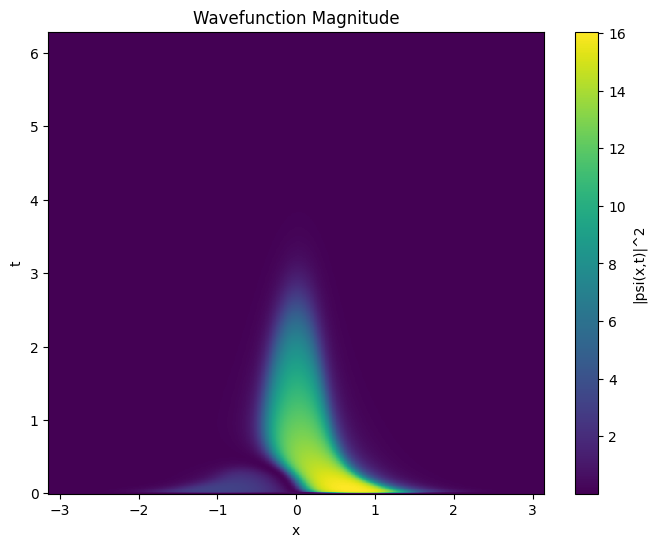

In [22]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wavefunction Magnitude')
plt.show()

In [23]:
psi_analytical_mag = psi_real_analytical ** 2 + psi_img_analytical ** 2
psi_pinn_mag = psi_real_pinn ** 2 + psi_img_pinn ** 2

mse = (np.square(psi_analytical_mag - psi_pinn_mag)).mean()

print(f"Mean Squared Error: {mse:.3e}")

Mean Squared Error: 5.064e+00
